# Agenda

1. Dates and times
2. Visualization
3. Optimization of queries
    - Memory usage (dtypes and categories)
    - Techniques for improving query speed
    - PyArrow

# Dates and times

When we use the word "time" in a human language, we actually mean two different things:

- A specific point in time, unique in the universe's history. We point to that time with a particular year, month, date, hour, minute, second, etc., depending on how fine-grained we want our measurement to be.  This is how we indicate when a class starts, or when a meeting ends, or when someone was born. In programming, we refer to this as a `datetime` or as a `timestamp`.

- We can also mean a span of time -- how long something lasts, or how long someone lived, or how long we've been working for a particular company. It's related to a `datetime`, but it's not the same. It's not anchored to a particular start or finish, it's just a span of time. In programming, we refer to this as a `timedelta` or an `interval`.

You can actually do math with these:

- `end_datetime` - `start_datetime` - `timedelta`  # how long did an event last?
- `end_datetime` - `timedelta` = `start_datetime` # when did something start, given the endpoint and the length?
- `start_datetime` + `timedelta` = `end_datetime`  # given a starting point and a length of time, when did it end?

Pandas supports both of these, as `datetime` and `timedelta` objects. We can have these objects in a series, and thus in a data frame.

In [1]:
import pandas as pd

df = pd.read_csv('taxi.csv')
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-06-02 11:19:29,2015-06-02 11:47:52,1,1.63,-73.954430,40.764141,1,N,-73.974754,40.754093,2,17.0,0.0,0.5,0.00,0.0,0.3,17.80
1,2,2015-06-02 11:19:30,2015-06-02 11:27:56,1,0.46,-73.971443,40.758942,1,N,-73.978539,40.761909,1,6.5,0.0,0.5,1.00,0.0,0.3,8.30
2,2,2015-06-02 11:19:31,2015-06-02 11:30:30,1,0.87,-73.978111,40.738434,1,N,-73.990273,40.745438,1,8.0,0.0,0.5,2.20,0.0,0.3,11.00
3,2,2015-06-02 11:19:31,2015-06-02 11:39:02,1,2.13,-73.945892,40.773529,1,N,-73.971527,40.760330,1,13.5,0.0,0.5,2.86,0.0,0.3,17.16
4,1,2015-06-02 11:19:32,2015-06-02 11:32:49,1,1.40,-73.979088,40.776772,1,N,-73.982162,40.758999,2,9.5,0.0,0.5,0.00,0.0,0.3,10.30


In [2]:
df.dtypes

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object

In [3]:
# how can we turn one or both of these columns into series with datetime dtypes?
# we can use pd.to_datetime

pd.to_datetime(df['tpep_pickup_datetime'])

0      2015-06-02 11:19:29
1      2015-06-02 11:19:30
2      2015-06-02 11:19:31
3      2015-06-02 11:19:31
4      2015-06-02 11:19:32
               ...        
9994   2015-06-01 00:12:59
9995   2015-06-01 00:12:59
9996   2015-06-01 00:13:00
9997   2015-06-01 00:13:02
9998   2015-06-01 00:13:04
Name: tpep_pickup_datetime, Length: 9999, dtype: datetime64[ns]

In [4]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
pickup_longitude                float64
pickup_latitude                 float64
RateCodeID                        int64
store_and_fwd_flag               object
dropoff_longitude               float64
dropoff_latitude                float64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
dtype: object

In [5]:
# it seems silly that we have to do this in two steps!
# isn't there a way for us to tell read_csv that these two columns should be interpreted as datetime values?
# yes -- we pass a keyword arguments, parse_dates, with the names (or numeric indexes) of the columns to handle that way

df = pd.read_csv('taxi.csv',
                 usecols=['tpep_pickup_datetime', 'tpep_dropoff_datetime',
                          'passenger_count', 'trip_distance', 'total_amount'],
                parse_dates=['tpep_pickup_datetime',
                             'tpep_dropoff_datetime'])
df.dtypes


tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
total_amount                    float64
dtype: object

# What about date formats?

Dates come in a *lot* of different formats. By default, Pandas can handle `YYYY-MM-DD HH:MM:SS` and a few other well-known, unambiguous formats. But there are also some ambiguous ones, such as `02-03-2024`, is that February 3rd? Or is that March 2nd? By default, because Pandas comes from the US, it assumes that the month comes first -- so this date would be February 3rd. If you want to change that, you can set `dayfirst=True` in `read_csv`.

If your dates come in a very weird format, you can pass the `date_format` keyword argument, which will then determine how Pandas interprets the dates. That format uses `strptime` and `strftime` formatting codes, using `%`. (Info at https://www.strfti.me/, a great site.)

# Once we have dates... so what?

The point of having `datetime` data is that you can pick it apart, and use the components. If we want to find out the year in which something happened, we want to grab that. We can also get the minutes, hours, or anything else.

That's all done via the `.dt` accessor, which works similarly to the `.str` accessor we saw yesterday. We take a `datetime` series (column), apply `.dt` and a specific component, and we get a new series back.

In [6]:
df['tpep_pickup_datetime'].dt.year

0       2015
1       2015
2       2015
3       2015
4       2015
        ... 
9994    2015
9995    2015
9996    2015
9997    2015
9998    2015
Name: tpep_pickup_datetime, Length: 9999, dtype: int32

In [8]:
df['tpep_pickup_datetime'].dt.second

0       29
1       30
2       31
3       31
4       32
        ..
9994    59
9995    59
9996     0
9997     2
9998     4
Name: tpep_pickup_datetime, Length: 9999, dtype: int32

In [10]:
# in addition to the "normal" things we can request, we can also get:

df['tpep_pickup_datetime'].dt.is_quarter_end

0       False
1       False
2       False
3       False
4       False
        ...  
9994    False
9995    False
9996    False
9997    False
9998    False
Name: tpep_pickup_datetime, Length: 9999, dtype: bool

In [11]:
df['tpep_pickup_datetime'].dt.is_leap_year

0       False
1       False
2       False
3       False
4       False
        ...  
9994    False
9995    False
9996    False
9997    False
9998    False
Name: tpep_pickup_datetime, Length: 9999, dtype: bool

In [12]:
df['tpep_pickup_datetime'].dt.days_in_month

0       30
1       30
2       30
3       30
4       30
        ..
9994    30
9995    30
9996    30
9997    30
9998    30
Name: tpep_pickup_datetime, Length: 9999, dtype: int32

In [13]:
df['tpep_pickup_datetime'].dt.day_of_week

0       1
1       1
2       1
3       1
4       1
       ..
9994    0
9995    0
9996    0
9997    0
9998    0
Name: tpep_pickup_datetime, Length: 9999, dtype: int32

In [14]:
df['tpep_pickup_datetime'].dt.day_name()

0       Tuesday
1       Tuesday
2       Tuesday
3       Tuesday
4       Tuesday
         ...   
9994     Monday
9995     Monday
9996     Monday
9997     Monday
9998     Monday
Name: tpep_pickup_datetime, Length: 9999, dtype: object

In [15]:
# let's find all of the taxi rides that took place when the hour is 11

df.loc[  df['tpep_pickup_datetime'].dt.hour == 11  ]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,total_amount
0,2015-06-02 11:19:29,2015-06-02 11:47:52,1,1.63,17.80
1,2015-06-02 11:19:30,2015-06-02 11:27:56,1,0.46,8.30
2,2015-06-02 11:19:31,2015-06-02 11:30:30,1,0.87,11.00
3,2015-06-02 11:19:31,2015-06-02 11:39:02,1,2.13,17.16
4,2015-06-02 11:19:32,2015-06-02 11:32:49,1,1.40,10.30
...,...,...,...,...,...
5055,2015-06-02 11:33:35,2015-06-02 11:42:16,1,0.73,7.80
5092,2015-06-02 11:33:35,2015-06-02 11:38:53,1,0.96,8.50
5093,2015-06-02 11:33:36,2015-06-02 11:52:32,2,3.50,18.80
5130,2015-06-02 11:33:35,2015-06-02 11:55:02,5,2.14,14.80


# Exericse: Taxi dates/times

1. Load the (large) NYC taxi data from January 2020, turning the two datetime columns into `datetime` values/dtypes.
2. What percentage of the values in this file are actually not from January 2020? (How many are from earlier, and how many are from later?)
3. What are the mean `trip_distance` and `total_amount` at each hour of the day?
4. What is the breakdown of rides on each day of the week? Which day is most popular? And which day is least?

In [16]:
filename = '/Users/reuven/Courses/Current/Data/nyc_taxi_2020-01.csv'

df = pd.read_csv(filename, low_memory=False,
                 parse_dates=['tpep_pickup_datetime',
                              'tpep_dropoff_datetime'])

In [17]:
df.dtypes

VendorID                        float64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                    float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

In [19]:
# What percentage of the values in this file are actually not from January 2020? (How many are from earlier, and how many are from later?)

df.loc[df['tpep_pickup_datetime'].dt.year < 2020]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
7,2.0,2019-12-18 15:27:49,2019-12-18 15:28:59,1.0,0.00,5.0,N,193,193,1.0,0.01,0.0,0.0,0.00,0.00,0.3,2.81,2.5
8,2.0,2019-12-18 15:30:35,2019-12-18 15:31:35,4.0,0.00,1.0,N,193,193,1.0,2.50,0.5,0.5,0.00,0.00,0.3,6.30,2.5
796,2.0,2019-12-31 23:48:07,2019-12-31 23:53:39,1.0,0.88,1.0,N,41,41,2.0,6.00,0.5,0.5,0.00,0.00,0.3,7.30,0.0
1276,2.0,2019-12-31 23:59:40,2020-01-01 00:09:06,2.0,2.19,1.0,N,231,158,1.0,9.50,0.5,0.5,2.66,0.00,0.3,15.96,2.5
1419,2.0,2019-12-31 23:56:19,2020-01-01 00:15:43,1.0,3.74,1.0,N,162,158,1.0,15.00,0.5,0.5,5.64,0.00,0.3,24.44,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4715309,2.0,2009-01-01 00:02:54,2009-01-01 00:02:58,1.0,0.01,1.0,N,264,264,2.0,2.50,0.0,0.5,0.00,0.00,0.3,3.30,0.0
5086498,2.0,2008-12-31 23:02:40,2009-01-01 05:46:33,1.0,8.48,1.0,N,43,138,1.0,24.00,0.5,0.5,6.78,6.12,0.3,40.70,2.5
5086894,2.0,2008-12-31 23:03:44,2009-01-01 05:32:14,1.0,1.10,1.0,N,262,140,1.0,6.00,0.5,0.5,1.00,0.00,0.3,10.80,2.5
5240836,2.0,2009-01-01 00:08:44,2009-01-01 02:50:15,1.0,4.56,1.0,N,170,41,1.0,15.00,0.5,0.5,3.76,0.00,0.3,22.56,2.5


In [22]:
(
    df
    .loc[lambda df_: ((df_['tpep_pickup_datetime'].dt.year == 2020) & (df_['tpep_pickup_datetime'].dt.month > 1) |
                      (df_['tpep_pickup_datetime'].dt.year > 2020))]
).shape

(51, 18)

In [24]:
(51 + 161) / df.shape[0]

3.309909995428577e-05

In [27]:
# we can actually compare datetime values with *strings*!

df.loc[df['tpep_pickup_datetime'] > '2020-01-31 23:59:59'].shape

(51, 18)

In [28]:
df.loc[df['tpep_pickup_datetime'] > '23:59:59 2020-01-31'].shape

(51, 18)

In [29]:
df.loc[df['tpep_pickup_datetime'] >= '2020-02-01'].shape

(51, 18)

In [30]:
# What are the mean trip_distance and total_amount at each hour of the day?

df.groupby(df['tpep_pickup_datetime'].dt.hour)[['trip_distance', 'total_amount']].mean()

,trip_distance,total_amount
tpep_pickup_datetime,,
0,3.473789,19.622096
1,3.127067,18.421611
2,3.041224,17.849248
3,3.336142,18.594672
4,4.235996,21.663218
5,4.934676,24.351221
6,3.634310,19.618494
7,3.754755,17.861858
8,2.554790,17.630640


In [33]:
# What is the breakdown of rides on each day of the week? Which day is most popular? And which day is least?

df['tpep_pickup_datetime'].dt.day_name().value_counts()

tpep_pickup_datetime
Friday       1124743
Thursday     1108598
Wednesday    1053369
Tuesday       849007
Saturday      813660
Monday        740468
Sunday        715163
Name: count, dtype: int64

In [34]:
# pass normalize=True to get percentages!
df['tpep_pickup_datetime'].dt.day_name().value_counts(normalize=True)

tpep_pickup_datetime
Friday       0.175604
Thursday     0.173083
Wednesday    0.164460
Tuesday      0.132554
Saturday     0.127035
Monday       0.115608
Sunday       0.111657
Name: proportion, dtype: float64

# `timedelta` objects

We saw before that we can create a `timedelta` by subtracting one `datetime` from another. We can do that here, to find out how long a taxi ride took.

In [35]:
df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

0         0 days 00:04:48
1         0 days 00:07:25
2         0 days 00:06:11
3         0 days 00:04:51
4         0 days 00:02:18
                ...      
6405003   0 days 00:31:00
6405004   0 days 01:16:00
6405005   0 days 00:27:50
6405006   0 days 00:22:39
6405007   0 days 00:22:00
Length: 6405008, dtype: timedelta64[ns]

In [36]:
# create a column with the timedelta, the amount of time that a ride took
df['trip_time'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [38]:
# once again, we can compare with strings
df.loc[df['trip_time'] > '1:00:00']   # which trips took longer than 1 hour?

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_time
41,2.0,2020-01-01 00:30:11,2020-01-01 01:31:29,1.0,0.80,1.0,N,48,68,2.0,18.50,1.30,0.5,0.00,0.00,0.0,22.80,2.5,0 days 01:01:18
84,2.0,2020-01-01 00:44:37,2020-01-01 01:46:33,1.0,6.70,1.0,N,50,7,1.0,38.50,0.50,0.5,8.46,0.00,0.3,50.76,2.5,0 days 01:01:56
430,2.0,2020-01-01 00:30:31,2020-01-01 01:44:14,1.0,8.92,1.0,N,170,238,2.0,38.00,0.50,0.5,0.00,0.00,0.3,41.80,2.5,0 days 01:13:43
1117,2.0,2020-01-01 00:30:07,2020-01-02 00:28:18,1.0,0.35,1.0,N,166,166,1.0,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0,0 days 23:58:11
1471,2.0,2020-01-01 00:41:24,2020-01-01 23:28:12,1.0,6.97,1.0,N,137,49,1.0,22.00,0.50,0.5,3.87,0.00,0.3,29.67,2.5,0 days 22:46:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6404846,NaN,2020-01-31 13:59:00,2020-01-31 15:00:00,NaN,8.33,NaN,NaN,68,61,NaN,29.89,2.75,0.5,0.00,0.00,0.3,33.44,0.0,0 days 01:01:00
6404861,NaN,2020-01-31 13:36:00,2020-01-31 14:46:00,NaN,24.14,NaN,NaN,262,86,NaN,73.83,2.75,0.5,0.00,6.12,0.3,83.50,0.0,0 days 01:10:00
6404908,NaN,2020-01-31 21:58:00,2020-01-31 23:09:00,NaN,10.75,NaN,NaN,263,61,NaN,36.21,2.75,0.5,0.00,0.00,0.3,39.76,0.0,0 days 01:11:00
6404968,NaN,2020-01-31 06:48:00,2020-01-31 07:54:00,NaN,16.58,NaN,NaN,139,162,NaN,45.79,2.75,0.5,0.00,6.12,0.3,55.46,0.0,0 days 01:06:00


In [39]:
# once again, we can compare with strings that include a number + a unit!

df.loc[df['trip_time'] > '1 hour']  

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_time
41,2.0,2020-01-01 00:30:11,2020-01-01 01:31:29,1.0,0.80,1.0,N,48,68,2.0,18.50,1.30,0.5,0.00,0.00,0.0,22.80,2.5,0 days 01:01:18
84,2.0,2020-01-01 00:44:37,2020-01-01 01:46:33,1.0,6.70,1.0,N,50,7,1.0,38.50,0.50,0.5,8.46,0.00,0.3,50.76,2.5,0 days 01:01:56
430,2.0,2020-01-01 00:30:31,2020-01-01 01:44:14,1.0,8.92,1.0,N,170,238,2.0,38.00,0.50,0.5,0.00,0.00,0.3,41.80,2.5,0 days 01:13:43
1117,2.0,2020-01-01 00:30:07,2020-01-02 00:28:18,1.0,0.35,1.0,N,166,166,1.0,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0,0 days 23:58:11
1471,2.0,2020-01-01 00:41:24,2020-01-01 23:28:12,1.0,6.97,1.0,N,137,49,1.0,22.00,0.50,0.5,3.87,0.00,0.3,29.67,2.5,0 days 22:46:48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6404846,NaN,2020-01-31 13:59:00,2020-01-31 15:00:00,NaN,8.33,NaN,NaN,68,61,NaN,29.89,2.75,0.5,0.00,0.00,0.3,33.44,0.0,0 days 01:01:00
6404861,NaN,2020-01-31 13:36:00,2020-01-31 14:46:00,NaN,24.14,NaN,NaN,262,86,NaN,73.83,2.75,0.5,0.00,6.12,0.3,83.50,0.0,0 days 01:10:00
6404908,NaN,2020-01-31 21:58:00,2020-01-31 23:09:00,NaN,10.75,NaN,NaN,263,61,NaN,36.21,2.75,0.5,0.00,0.00,0.3,39.76,0.0,0 days 01:11:00
6404968,NaN,2020-01-31 06:48:00,2020-01-31 07:54:00,NaN,16.58,NaN,NaN,139,162,NaN,45.79,2.75,0.5,0.00,6.12,0.3,55.46,0.0,0 days 01:06:00


In [40]:
# to drop a column, you use df.drop, pass a string (one column) or a list (for multple columns) as the value to the 
# columns= keyword argument

df = df.drop(columns=['store_and_fwd_flag', 'PULocationID'])
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_time
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.20,1.0,239,1.0,6.00,3.00,0.5,1.47,0.00,0.3,11.27,2.5,0 days 00:04:48
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.20,1.0,238,1.0,7.00,3.00,0.5,1.50,0.00,0.3,12.30,2.5,0 days 00:07:25
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.60,1.0,238,1.0,6.00,3.00,0.5,1.00,0.00,0.3,10.80,2.5,0 days 00:06:11
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.80,1.0,151,1.0,5.50,0.50,0.5,1.36,0.00,0.3,8.16,0.0,0 days 00:04:51
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.00,1.0,193,2.0,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0,0 days 00:02:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405003,NaN,2020-01-31 22:51:00,2020-01-31 23:22:00,NaN,3.24,NaN,234,NaN,17.59,2.75,0.5,0.00,0.00,0.3,21.14,0.0,0 days 00:31:00
6405004,NaN,2020-01-31 22:10:00,2020-01-31 23:26:00,NaN,22.13,NaN,45,NaN,46.67,2.75,0.5,0.00,12.24,0.3,62.46,0.0,0 days 01:16:00
6405005,NaN,2020-01-31 22:50:07,2020-01-31 23:17:57,NaN,10.51,NaN,169,NaN,48.85,2.75,0.0,0.00,0.00,0.3,51.90,0.0,0 days 00:27:50
6405006,NaN,2020-01-31 22:25:53,2020-01-31 22:48:32,NaN,5.49,NaN,42,NaN,27.17,2.75,0.0,0.00,0.00,0.3,30.22,0.0,0 days 00:22:39


In [41]:
# we can move a column by retrieving the columns using [[]] and then assigning those back to the data frame

df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'trip_time'],
      dtype='object')

In [42]:
df[['trip_time', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge']]

,trip_time,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,0 days 00:04:48,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.20,1.0,239,1.0,6.00,3.00,0.5,1.47,0.00,0.3,11.27,2.5
1,0 days 00:07:25,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.20,1.0,238,1.0,7.00,3.00,0.5,1.50,0.00,0.3,12.30,2.5
2,0 days 00:06:11,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.60,1.0,238,1.0,6.00,3.00,0.5,1.00,0.00,0.3,10.80,2.5
3,0 days 00:04:51,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.80,1.0,151,1.0,5.50,0.50,0.5,1.36,0.00,0.3,8.16,0.0
4,0 days 00:02:18,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.00,1.0,193,2.0,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405003,0 days 00:31:00,NaN,2020-01-31 22:51:00,2020-01-31 23:22:00,NaN,3.24,NaN,234,NaN,17.59,2.75,0.5,0.00,0.00,0.3,21.14,0.0
6405004,0 days 01:16:00,NaN,2020-01-31 22:10:00,2020-01-31 23:26:00,NaN,22.13,NaN,45,NaN,46.67,2.75,0.5,0.00,12.24,0.3,62.46,0.0
6405005,0 days 00:27:50,NaN,2020-01-31 22:50:07,2020-01-31 23:17:57,NaN,10.51,NaN,169,NaN,48.85,2.75,0.0,0.00,0.00,0.3,51.90,0.0
6405006,0 days 00:22:39,NaN,2020-01-31 22:25:53,2020-01-31 22:48:32,NaN,5.49,NaN,42,NaN,27.17,2.75,0.0,0.00,0.00,0.3,30.22,0.0


# Exercise: `timedelta`

1. How many rides in January 2020 took longer than 1 day? How far did those passengers go, and how much did they pay?
2. For rides that took between 10 and 20 minutes, what was the average distance?
3. How many rides took less than 1 second? How far did they go, and how much did they pay?

In [46]:
df['trip_time'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['trip_time'].describe()

count                      6405008
mean     0 days 00:15:57.004676965
std      0 days 01:03:13.799494584
min              -2 days +01:49:38
25%                0 days 00:06:22
50%                0 days 00:10:29
75%                0 days 00:16:50
max                5 days 22:05:07
Name: trip_time, dtype: object

In [51]:
# How many rides in January 2020 took longer than 1 day? How far did those passengers go, and how much did they pay?

df.loc[
    df['trip_time'] > '1 day',   # row selector
    ['trip_distance', 'total_amount']
].mean()

trip_distance      6.368000
total_amount     409.039333
dtype: float64

In [54]:
# For rides that took between 10 and 20 minutes, what was the average distance?

(
    df
    .loc[lambda df_: df_['trip_time'] >= '10 minutes']
    .loc[lambda df_: df_['trip_time'] <= '20 minutes', 'trip_distance']
    .mean()
)


np.float64(2.630514769537913)

In [58]:
# How many rides took less than 1 second? How far did they go, and how much did they pay?

df.loc[df['trip_time'] < '1 second',
    ['trip_distance', 'total_amount']].mean()

trip_distance     0.080225
total_amount     19.751995
dtype: float64

# Time series

When a `datetime` column is turned into the index of a data frame, we refer to this as a "time series." We get a few extra pieces of functionality when this is the case.

In [59]:
df = df.set_index('tpep_pickup_datetime')
df

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_time
tpep_pickup_datetime,,,,,,,,,,,,,,,,
2020-01-01 00:28:15,1.0,2020-01-01 00:33:03,1.0,1.20,1.0,239,1.0,6.00,3.00,0.5,1.47,0.00,0.3,11.27,2.5,0 days 00:04:48
2020-01-01 00:35:39,1.0,2020-01-01 00:43:04,1.0,1.20,1.0,238,1.0,7.00,3.00,0.5,1.50,0.00,0.3,12.30,2.5,0 days 00:07:25
2020-01-01 00:47:41,1.0,2020-01-01 00:53:52,1.0,0.60,1.0,238,1.0,6.00,3.00,0.5,1.00,0.00,0.3,10.80,2.5,0 days 00:06:11
2020-01-01 00:55:23,1.0,2020-01-01 01:00:14,1.0,0.80,1.0,151,1.0,5.50,0.50,0.5,1.36,0.00,0.3,8.16,0.0,0 days 00:04:51
2020-01-01 00:01:58,2.0,2020-01-01 00:04:16,1.0,0.00,1.0,193,2.0,3.50,0.50,0.5,0.00,0.00,0.3,4.80,0.0,0 days 00:02:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 22:51:00,NaN,2020-01-31 23:22:00,NaN,3.24,NaN,234,NaN,17.59,2.75,0.5,0.00,0.00,0.3,21.14,0.0,0 days 00:31:00
2020-01-31 22:10:00,NaN,2020-01-31 23:26:00,NaN,22.13,NaN,45,NaN,46.67,2.75,0.5,0.00,12.24,0.3,62.46,0.0,0 days 01:16:00
2020-01-31 22:50:07,NaN,2020-01-31 23:17:57,NaN,10.51,NaN,169,NaN,48.85,2.75,0.0,0.00,0.00,0.3,51.90,0.0,0 days 00:27:50


# Special feature #1: Retrieval of rows

We know that if we use `.loc`, we can retrieve one or more rows corresponding to the index that we enter. If the index contains `datetime` values, then we can leave off more specific parts of the `datetime`, and those are then considered to be wildcard matches.

So if we leave off the seconds, then *any* seconds will match. If we leave off minutes and seconds, then any minutes/seconds in that hour will match

In [61]:
df.loc['2020-01-31 22:44:01']

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_time
tpep_pickup_datetime,,,,,,,,,,,,,,,,
2020-01-31 22:44:01,1.0,2020-01-31 22:46:06,2.0,0.50,1.0,33,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,0 days 00:02:05
2020-01-31 22:44:01,1.0,2020-01-31 23:32:03,1.0,10.30,1.0,181,1.0,37.0,3.0,0.5,10.15,0.0,0.3,50.95,2.5,0 days 00:48:02
2020-01-31 22:44:01,1.0,2020-01-31 22:53:19,1.0,1.70,1.0,143,1.0,8.0,3.0,0.5,1.77,0.0,0.3,13.57,2.5,0 days 00:09:18
2020-01-31 22:44:01,2.0,2020-01-31 22:56:52,1.0,1.58,1.0,79,1.0,9.5,0.5,0.5,2.00,0.0,0.3,15.30,2.5,0 days 00:12:51


In [62]:
# let's leave off the seconds - -this will match any second count from 00-59

df.loc['2020-01-31 22:44']

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_time
tpep_pickup_datetime,,,,,,,,,,,,,,,,
2020-01-31 22:44:28,2.0,2020-01-31 22:53:11,2.0,1.11,1.0,234,2.0,7.50,0.50,0.5,0.00,0.00,0.3,11.30,2.5,0 days 00:08:43
2020-01-31 22:44:00,1.0,2020-01-31 23:11:54,1.0,16.30,2.0,170,1.0,52.00,2.50,0.5,12.25,6.12,0.3,73.67,2.5,0 days 00:27:54
2020-01-31 22:44:59,2.0,2020-01-31 22:57:26,4.0,2.83,1.0,238,1.0,11.50,0.50,0.5,3.06,0.00,0.3,18.36,2.5,0 days 00:12:27
2020-01-31 22:44:56,2.0,2020-01-31 22:52:44,2.0,1.76,1.0,263,1.0,8.00,0.50,0.5,2.36,0.00,0.3,14.16,2.5,0 days 00:07:48
2020-01-31 22:44:09,2.0,2020-01-31 23:02:55,1.0,2.99,1.0,255,1.0,14.50,0.50,0.5,2.00,0.00,0.3,20.30,2.5,0 days 00:18:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 22:44:49,1.0,2020-01-31 22:50:51,1.0,0.30,1.0,230,3.0,5.50,3.00,0.5,0.00,0.00,0.3,9.30,2.5,0 days 00:06:02
2020-01-31 22:44:13,2.0,2020-01-31 23:06:17,1.0,3.12,1.0,233,1.0,15.50,0.50,0.5,3.86,0.00,0.3,23.16,2.5,0 days 00:22:04
2020-01-31 22:44:29,2.0,2020-01-31 22:54:04,2.0,1.31,1.0,230,2.0,8.00,0.50,0.5,0.00,0.00,0.3,11.80,2.5,0 days 00:09:35


In [63]:
# leave off minutes + seconds
df.loc['2020-01-31 22']

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_time
tpep_pickup_datetime,,,,,,,,,,,,,,,,
2020-01-31 22:02:16,2.0,2020-02-01 21:55:59,4.0,0.93,1.0,68,2.0,8.00,0.00,0.5,0.00,0.00,0.3,11.30,2.5,0 days 23:53:43
2020-01-31 22:19:07,2.0,2020-01-31 22:26:24,4.0,1.08,1.0,249,1.0,6.50,0.00,0.5,1.96,0.00,0.3,11.76,2.5,0 days 00:07:17
2020-01-31 22:28:07,2.0,2020-01-31 22:33:36,4.0,0.76,1.0,125,1.0,5.50,0.00,0.5,1.00,0.00,0.3,9.80,2.5,0 days 00:05:29
2020-01-31 22:34:55,2.0,2020-01-31 22:56:43,4.0,3.92,1.0,255,1.0,17.00,0.00,0.5,4.06,0.00,0.3,24.36,2.5,0 days 00:21:48
2020-01-31 22:00:18,2.0,2020-01-31 22:15:05,2.0,3.35,1.0,238,2.0,13.50,0.50,0.5,0.00,0.00,0.3,17.30,2.5,0 days 00:14:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 22:51:00,NaN,2020-01-31 23:22:00,NaN,3.24,NaN,234,NaN,17.59,2.75,0.5,0.00,0.00,0.3,21.14,0.0,0 days 00:31:00
2020-01-31 22:10:00,NaN,2020-01-31 23:26:00,NaN,22.13,NaN,45,NaN,46.67,2.75,0.5,0.00,12.24,0.3,62.46,0.0,0 days 01:16:00
2020-01-31 22:50:07,NaN,2020-01-31 23:17:57,NaN,10.51,NaN,169,NaN,48.85,2.75,0.0,0.00,0.00,0.3,51.90,0.0,0 days 00:27:50


# Resampling

If our index is a `datetime` series, then we can *resample*, which is a special kind of `groupby`. We've seen that we can run `groupby` on a component of a `datetime` column, and then we'll get results for each unique value that it returns.

If we use `resample`, then Pandas will give us a report from the initial (first) `datetime` value, to the final (last) `datetime` value, including any dates and times in between (even if they aren't in the index). We indicate the granularity with which it should perform its grouping. As with `groupby`, we specify which column(s) we want to invoke it on, and which method(s) we want to run.

In [66]:
df.resample('1D')['trip_distance'].mean().dropna()

tpep_pickup_datetime
2003-01-01    0.000000
2008-12-31    6.284000
2009-01-01    4.895263
2019-12-18    0.000000
2019-12-31    3.209845
2020-01-01    3.492559
2020-01-02    3.276178
2020-01-03    2.971490
2020-01-04    2.938824
2020-01-05    3.303956
2020-01-06    3.077634
2020-01-07    2.859923
2020-01-08    2.803441
2020-01-09    2.804815
2020-01-10    2.876713
2020-01-11    2.810616
2020-01-12    3.172434
2020-01-13    2.950095
2020-01-14    2.793715
2020-01-15    2.837513
2020-01-16    2.790732
2020-01-17    2.801828
2020-01-18    2.683998
2020-01-19    3.004146
2020-01-20    3.240864
2020-01-21    2.824365
2020-01-22    2.739187
2020-01-23    2.827696
2020-01-24    2.804043
2020-01-25    2.569285
2020-01-26    3.104444
2020-01-27    2.968993
2020-01-28    3.702186
2020-01-29    2.730200
2020-01-30    2.803967
2020-01-31    2.818991
2020-02-01    3.500000
2020-02-02    1.010000
2020-02-12    0.996667
2020-02-23    6.290000
2020-03-04    1.190000
2020-03-16    1.210000
2020-03-25   

Offset codes for `resample`: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

In [70]:
df['trip_time'].dt.seconds

tpep_pickup_datetime
2020-01-01 00:28:15     288
2020-01-01 00:35:39     445
2020-01-01 00:47:41     371
2020-01-01 00:55:23     291
2020-01-01 00:01:58     138
                       ... 
2020-01-31 22:51:00    1860
2020-01-31 22:10:00    4560
2020-01-31 22:50:07    1670
2020-01-31 22:25:53    1359
2020-01-31 22:44:00    1320
Name: trip_time, Length: 6405008, dtype: int32

In [71]:
df['trip_time'].dt.days

tpep_pickup_datetime
2020-01-01 00:28:15    0
2020-01-01 00:35:39    0
2020-01-01 00:47:41    0
2020-01-01 00:55:23    0
2020-01-01 00:01:58    0
                      ..
2020-01-31 22:51:00    0
2020-01-31 22:10:00    0
2020-01-31 22:50:07    0
2020-01-31 22:25:53    0
2020-01-31 22:44:00    0
Name: trip_time, Length: 6405008, dtype: int64

In [73]:
df['trip_time'].dt.microseconds

tpep_pickup_datetime
2020-01-01 00:28:15    0
2020-01-01 00:35:39    0
2020-01-01 00:47:41    0
2020-01-01 00:55:23    0
2020-01-01 00:01:58    0
                      ..
2020-01-31 22:51:00    0
2020-01-31 22:10:00    0
2020-01-31 22:50:07    0
2020-01-31 22:25:53    0
2020-01-31 22:44:00    0
Name: trip_time, Length: 6405008, dtype: int32

In [74]:
df['trip_time'].dt.total_seconds()   # this returns the length of the timedelta as a float, the number of seconds

tpep_pickup_datetime
2020-01-01 00:28:15     288.0
2020-01-01 00:35:39     445.0
2020-01-01 00:47:41     371.0
2020-01-01 00:55:23     291.0
2020-01-01 00:01:58     138.0
                        ...  
2020-01-31 22:51:00    1860.0
2020-01-31 22:10:00    4560.0
2020-01-31 22:50:07    1670.0
2020-01-31 22:25:53    1359.0
2020-01-31 22:44:00    1320.0
Name: trip_time, Length: 6405008, dtype: float64

# Exercise: Resampling

1. Looking only at dates in January 2020, on what three days did taxis bring in the most amount of money?
2. What was the total number of miles traveled in each 8-hour period of January 2020? Which were the three highest? Which were the three lowest?

In [76]:
df.resample('1D')

In [81]:
(
    df
    .loc['2020-01']
    .resample('1D')['total_amount'].sum()
    .nlargest(3)
)

tpep_pickup_datetime
2020-01-30    4604283.85
2020-01-17    4558896.44
2020-01-16    4506779.92
Name: total_amount, dtype: float64

In [82]:
(
    df
    .loc['2020-01']
    .resample('3D')['total_amount'].sum() 
    .nlargest(1)
)

tpep_pickup_datetime
2020-01-22    12880617.15
Freq: 3D, Name: total_amount, dtype: float64

In [86]:
# What was the total number of miles traveled in each 8-hour period of January 2020? Which were the three highest? Which were the three lowest?

(
    df
    .loc['2020-01']
    .resample('8h')['trip_distance'].sum()
    .nlargest(3)
)

tpep_pickup_datetime
2020-01-30 16:00:00    334459.16
2020-01-16 16:00:00    322108.33
2020-01-23 16:00:00    320097.62
Name: trip_distance, dtype: float64

In [87]:
(
    df
    .loc['2020-01']
    .resample('8h')['trip_distance'].sum()
    .nsmallest(3)
)

tpep_pickup_datetime
2020-01-02    67818.58
2020-01-20    72065.69
2020-01-03    75662.82
Name: trip_distance, dtype: float64

In [88]:
!cal 1 2020

    January 2020      
Su Mo Tu We Th Fr Sa  
          1  2  3  4  
 5  6  7  8  9 10 11  
12 13 14 15 16 17 18  
19 20 21 22 23 24 25  
26 27 28 29 30 31     
                      


# Next up: Visualization

Resume at :50

# How do we create plots?

The biggest and most popular package in Python for plotting is known as Matplotlib. My favorite way to create plots is with Pandas, which has an API that wraps around Matplotlib, and allows us to use it in a constrained and useful way.

Another library, Seaborn, has the same approach -- it uses Matplotlib, but provides its own, higher-level API.

- Pandas plotting with series
- How that extends to data frames
- Special data-frame plotting (i.e., scatterplots)

In [89]:
from pandas import Series, DataFrame

In [90]:
import numpy as np

np.random.seed(0)
s = Series(np.random.randint(0, 100, 10),
           index=list('abcdefghij'))
s

a    44
b    47
c    64
d    67
e    67
f     9
g    83
h    21
i    36
j    87
dtype: int64

<Axes: >

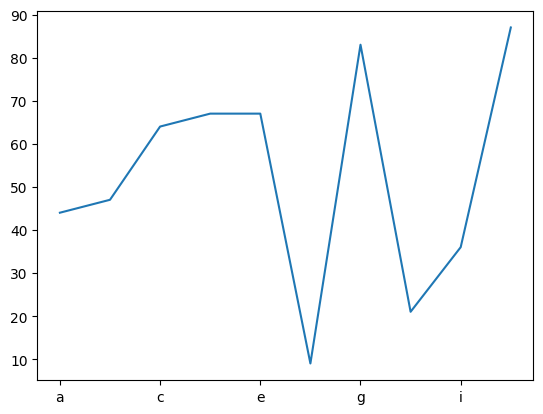

In [91]:
# if I want to plot this from within Pandas, I can invoke .plot -- or better yet, .plot.line()

s.plot.line()

<Axes: >

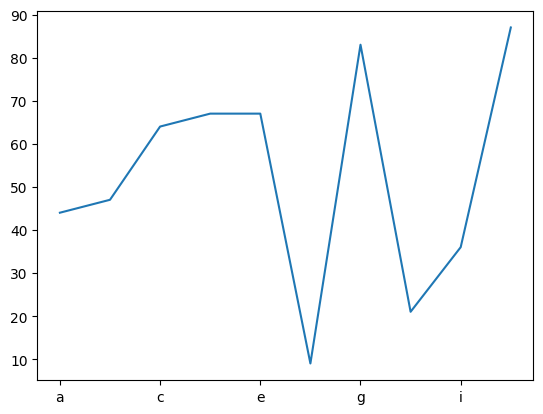

In [94]:
s.plot(kind='line')  # this lets me specify which kind of plot I want as an argument... but the default is 'line'

<Axes: >

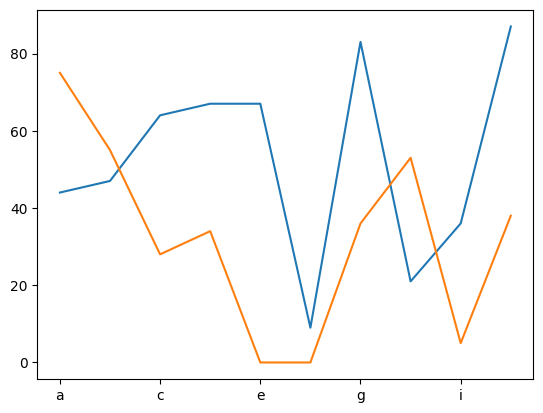

In [102]:
# calling plot.line (or any other plotting method) returns a Matplotlib "axes" object

ax = s.plot.line()    # this creates the plot object, and returns the Matplotlib "axes"

t = Series(np.random.randint(0, 100, 10), 
           index=list('abcdefghij'))

t.plot.line(ax=ax)    # plot this on the existing axes object, ax

<Axes: title={'center': 'My amazing plot'}>

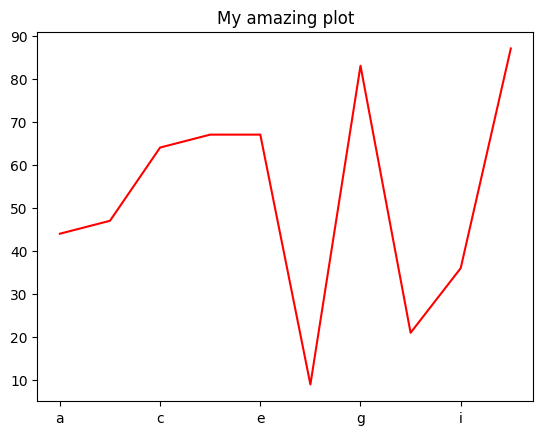

In [109]:
# plotting takes many keyword arguments that affect how the plot looks

s.plot.line(title='My amazing plot', color='red')